# Recherche de modèles pour la prédiction de la consommation d'énergie et des émissions de gaz à effets de serre

## Sommaire

* [1 - Préparation du notebook](#chapter1)


* [2 - Prédiction de la consommation d'énergie](#chapter2)
    * [2.1. Création d'un modèle "baseline"](#section_2_1)
        * [2.1.1. Préparation des données](#section_2_1_1)
        * [2.1.2. Création d'un modèle de base](#section_2_1_2)
        * [2.1.3. Evaluation du modèle avec le jeu de test](#section_2_1_3)
    * [2.2. Choix du modèle le plus adapté](#section_2_2)
    * [2.3. Choix des hyperparamètres](#section_2_3)
    * [2.4. Analyses des erreurs](#section_2_4)
    * [2.5. Pipeline final](#section_2_5)
    
    
* [3 - Prédiction des émissions de gaz à effets de serre](#chapter3)
    * [3.1. Préparation des variables](#section_3_1)
    * [3.2. Création d'un modèle "baseline"](#section_3_2)
    * [3.3. Choix du modèle le plus adapté](#section_3_3)
    * [3.4. Choix des hyperparamètres](#section_3_4)
    * [3.5. Analyses des erreurs](#section_3_5)
    * [3.6. Pipeline finale](#section_3_6)
    
* [4 - Prédiction des émissions de gaz à effets de serre à l'aide de l'ENERGYSTAR Score](#chapter4)

* [5 - Conclusion](#chapter5)

# 1) Préparation du notebook <a class="anchor" id="chapter1"></a>

In [1]:
# importation des librairies nécessaires aux tests de modèle
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, prediction_error

In [2]:
# Paramétrage visuelle de Scikit-Learn
sklearn.set_config(display="diagram")

In [3]:
# Fonction créée pour l'évaluation des modèles
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred)
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse.round(5))
    print("R²: ", r_score.round(5))

In [4]:
# importation des données
data = pd.read_csv("datasets/benchmark_total.csv")
data.head(3)

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Latitude,Longitude,NbofFloors,NbofBuildings,Age,Bins_Age,degreeDaysH,degreeDaysC,HasParking,Clusters
0,Hotel,Downtown,1927,1.0,12.0,88434,65.0,6981428.0,249.43,47.61220,-122.33799,2+f,1b,88,Very Old,4005,409,No,1
1,Hotel,Downtown,1927,1.0,12.0,88434,60.0,7226362.5,249.98,47.61220,-122.33799,2+f,1b,89,Very Old,4093,252,No,1
2,Hotel,Downtown,1996,1.0,11.0,103566,51.0,8354235.0,263.51,47.61317,-122.33393,2+f,1b,19,Recent,4005,409,Yes,1


Une fois que l'on a chargé les données, on va pouvoir séparer notre jeu de données en deux parties : un train set et un test set. On ne va pas toucher aux données du test set car il nous servia pour la validation de notre modèle. C'est grâce à ce jeu de données que l'on pourra sortir les metrics nécessaires. Dans chaque jeu (entraînement et test), on supprime les variables qui ne seront pas utiles dans notre modélisation. 

Tout d'abord, on supprime les variables que l'on cherche à prédire. "SiteEnergyUse(kBtu)" et "TotalGHGEmissions" sont les deux cibles que l'on cherche à prédire, on les mettra donc dans une variable y. Ensuite, notre jeu de données comporte de nombreuses valeurs : certaines sont d'origine et d'autres proviennent d'une opération de feature engineering. On va donc supprimer les doublons pour éviter la fuite de donneés. 
- Le score ENERGYSTAR est enlevé car on ne va pas s'en servir pour prédire la consommation d'énergie. On regardera son impact dans la prédiction des effets de gaz à effets de serre dans un second temps. 
- L'âge et l'année de construction des bâtiments sont supprimées. On va leur préférence l'utilisation d'une variable catégorielle en 4 modalités pour avoir cette information. La construction de cette variable est expliquée dans la partie "Analyse".
- Le nombre de bâtiments est supprimé et est remplacé par une variable catégorielle qui indique s'il y a 0, 1 ou 2 et plus de bâtiments sur la propriété. Ainsi la compréhension du modèle sera simpligiée par la suite.
- Pour le nombre d'étages, la logique est identique à celle du nombre de bâtiments. Ces simplifications permettent aussi de palier à la "mauvaise" distribution de nos variables. 
- Le quartier est supprimé ainsi que la longitude et la latitude. Ces informations concernent la localisation de la propriété. L'information de la localisation se trouve dans la variable "Cluster". Les explications de la création de cette variable se trouvent dans le notebook d'analyse. 

In [5]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set["SiteEnergyUse(kBtu)"].values
y_test = test_set["SiteEnergyUse(kBtu)"].values
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "ENERGYSTARScore", "Age", "YearBuilt", "NumberofBuildings", "NumberofFloors","Neighborhood", "Latitude", "Longitude"], axis=1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = np.log(y_train)
y_test = np.log(y_test)

# 2) Prédiction de la consommation d'énergie <a class="anchor" id="chapter2"></a>

## 2.1) Création d'un modèle "baseline" <a class="anchor" id="section_2_1"></a>

### 2.1.1) Préparation des données <a class="anchor" id="section_2_1_1"></a>

On sépare les variables catégorielles des variables numériques. Pour pouvoir leur appliquer des traitements différents qui seront enregistrés dans un pipeline de préprocessing. 
Pour les variables catégorielles : 
- On complète les valeurs manquantes par le mode (celle qui est le plus fréquent)
- On les transforme via un OneHotEncoding. Ainsi, elles seront transformées en valeur numérique compréhensible par notre modèles.

Pour les variables numériques : 
- On complète les valeurs manquantes par la médiane. Il y a une grande diversité dans nos valeurs numériques sans que cela soit des anomalies. Néanmoins, elles vont faire varier notre moyenne, c'est pourquoi on choisi ici la médiane.
- On standardise nos variables pour enlever les unités qui sont différents (degré Fahrenheit pour Degree Days Heating & Cooling ; sq/ft² pour la taille de la propriété).

In [6]:
# Séparation des variables catégorielles et numériques

cat_var = ["PrimaryPropertyType", "NbofFloors", "NbofBuildings", "HasParking", "Clusters", "Bins_Age"]
num_var = ["PropertyGFATotal", "degreeDaysH", "degreeDaysC"]

In [7]:
# Création d'un pipeline de transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [8]:
X_train = preprocessor.fit_transform(X_train)

### 2.1.2) Création du modèle de base <a class="anchor" id="section_2_1_2"></a>

Le modèle choisi pour obtenir une baseline est un modèle naïf. Ce type de modèle prédit la valeur médiane de la variable cible. Le but étant d'avoir une prédiction proche de ce que ferait un modèle basé sur le hasard. Les métriques qui sortiront de ce modèle serviront de base pour évaluer les performances d'autres modèles. 

In [9]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

### 2.1.3) Evaluation du modèle avec le jeu de test <a class="anchor" id="section_2_1_3"></a>

In [10]:
X_test = preprocessor.transform(X_test)
y_pred = dummy_reg.predict(X_test)
regression_metrics(y_test, y_pred)

MAE:  0.98081
MSE:  450979954418542.56
RMSE:  21236288.62157
R²:  -4e-05


Les métriques choisis sont le (R)MSE, le MAE et le R².

## 2.2) Choix du modèle le plus performant <a class="anchor" id="section_2_2"></a>

Le problème à laquelle nous sommes confrontés est un problème de régression. On va donc choisir des modèles qui peuvent permettre de faire ce type de prédiction. On va choisir des méthodes linéaires : Régression linéaire et ses variantes régularisées (Ridge et Lasso), le Support Vecteur Machine et des méthodes non linéaires : la régression linéaire ridge avec noyau, des méthodes ensemblistes de bagging (Bagging, Random Forest) et de boosting (AdaBoost, Gradient Boosting, XGBoost).

In [11]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
mlp_reg = MLPRegressor(random_state=42)

In [12]:
model = [dummy_reg, lin_reg, ridge, lasso, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost, mlp_reg]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
    rmse = mse ** (1/2)
    r_score = r2_score(y_test, y_pred)
    dict_model[model] = (mae, mse, rmse, r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost", "MLP"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost,MLP
MAE,9.808149e-01,7.151888e-01,7.112743e-01,1.007625e+00,3.278798e-01,5.473008e-01,7.117533e-01,6.064872e-01,3.663176e-01,4.601063e-01,3.502236e-01,3.450872e-01,5.179417e-01
MSE,4.509800e+14,2.547471e+14,2.653755e+14,4.471161e+14,1.891915e+14,2.232657e+14,2.631024e+14,2.613157e+14,6.098989e+13,1.792242e+14,8.361373e+13,9.155964e+13,1.589495e+14
RMSE,2.123629e+07,1.596080e+07,1.629035e+07,2.114512e+07,1.375469e+07,1.494208e+07,1.622043e+07,1.616526e+07,7.809602e+06,1.338746e+07,9.144054e+06,9.568680e+06,1.260752e+07
R²,-3.889412e-05,4.782263e-01,4.808725e-01,-1.326149e-02,7.879352e-01,6.663471e-01,4.806487e-01,5.877953e-01,8.286845e-01,7.490699e-01,8.438963e-01,8.552207e-01,6.989293e-01


La régression naïve apparaît bien comme l'un des modèles les moins performant. On remarque que les modèles linéaires (Régression linéaire, Régression Ridge/Lasso et SVM) ont un coefficient de détermination aux alentours de 50%. Cela montre que notre problème n'est pas un problème linéaire. On va donc devoir se tourner vers des méthodes linéaires. Le modèle de Random Forest et celui de XGBoost sont ceux qui performent le mieux. On va donc s'orienter sur un modèle de XGBoost. Ces hyperparamètres seront affinés pour obtenir la meilleure performance de notre modèle. 


**Choix du modèle :** XGBoost

## 2.3) Choix des hyperparamètres <a class="anchor" id="section_2_3"></a>

On va déjà définir quelques paramètres de notre algorithme de XGBoost. On va choisir de booster un modèle se basant sur des arbres de décision (gbtree), on va ensuite fixer sa racine aléatoire et on va fixer un nombre d'arbres dans notre algorithme. On choisit d'utiliser 400 arbres. 

In [13]:
xgboost_energy = xgb.XGBRegressor(objective="reg:squarederror", booster="gbtree", 
                               random_state=42, n_estimators=400, tree_method="hist", n_jobs=-1)

Une fois le modèle choisi, on va pouvoir s'occuper de ces hyperparamètres. On va s'interesser à la profondeur des arbres, à son coût d'apprentissage, à son paramètre gamma et à la méthode utilisée pour le boostraping. 

In [14]:
from sklearn.model_selection import GridSearchCV

params = [{"max_depth" : [7, 8, 9, 10, 11, 12],
           "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
           "gamma" : [3, 4, 5],
           "min_child_weight" : [2, 3, 4, 5], 
           "sampling_method" : ["uniform", "gradient_based"]
}]

grid_search = GridSearchCV(xgboost_energy, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_j...
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method='hist',
                                    validate_parameters=None, verbosity=None),
             param_grid=[{'gamma': [3, 4, 5],
                          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                                            0.3],
                          'max_depth': [7, 8, 9, 10, 11, 12],
                          'min_child_weight': [2, 3, 4, 5],
                          'sampling_method': ['uniform', 'gradient_based']}],
             scoring='neg_mean_squared_error')

In [15]:
grid_search.best_params_

{'gamma': 3,
 'learning_rate': 0.25,
 'max_depth': 12,
 'min_child_weight': 2,
 'sampling_method': 'uniform'}

In [16]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=12,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, sampling_method='uniform',
             scale_pos_weight=1, subsample=1, tree_method='hist',
             validate_parameters=1, verbosity=None)

Notre modèle est enregistré dans la grille de recherche. On va ensuite l'affecter à une variable pour tester ces performances sur un jeu de test. 

## 2.4) Analyse des erreurs du modèle <a class="anchor" id="section_2_4"></a>

Une fois le modèle sélectionné et les hyperparamètres choisis, on va pouvoir évaluer les performances du modèle sur un jeu qu'il n'a pas encore vu : le jeu de test. 

In [17]:
final_model_energy = grid_search.best_estimator_

In [18]:
final_predictions_energy = final_model_energy.predict(X_test)

In [19]:
regression_metrics(y_test, final_predictions_energy)

MAE:  0.45395
MSE:  172403458589462.12
RMSE:  13130249.75351
R²:  0.75959


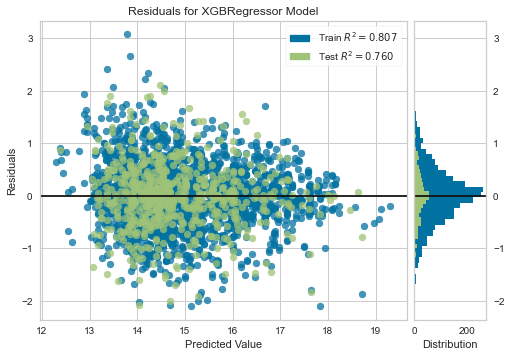

In [20]:
visualizer = ResidualsPlot(final_model_energy)
visualizer.fit(X_train, y_train.reshape(2596,))
visualizer.score(X_test, y_test.reshape(649,))
visualizer.show();

Les distributions des résidus du jeu d'entraînement et du jeu de test semblent suivre une loi normale. La distribution des résidus du jeu de test est plus aplatie. Cela peut s'expliquer par le nombre de données moins importants (seulement 20% de l'échantillon). 

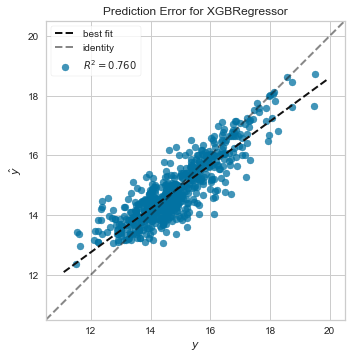

In [21]:
visualizer = prediction_error(final_model_energy, X_train, y_train, X_test, y_test);

## 2.5) Pipeline du modèle pour l'estimation de la consommation d'énergie <a class="anchor" id="section_2_5"></a>

In [22]:
from sklearn.pipeline import Pipeline

full_pipeline_energy = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_energy)
])

# 3) Prédiction des émissions de CO2 <a class="anchor" id="chapter3"></a>

Pour la prédiction des émissions de CO2, la méthode est la même que pour la prédiction de la consommation d'énergie.

## 3.1) Préparation des variables <a class="anchor" id="section_3_1"></a>

In [23]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set["TotalGHGEmissions"].values
y_test = test_set["TotalGHGEmissions"].values
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "ENERGYSTARScore", "YearBuilt", "Age", "NumberofFloors", "NumberofBuildings", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "ENERGYSTARScore", "YearBuilt", "Age", "NumberofFloors", "NumberofBuildings", 'Neighborhood', "Latitude", "Longitude"], axis=1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [24]:
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

## 3.2) Création d'un modèle de base <a class="anchor" id="section_3_2"></a>

In [25]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [26]:
y_pred = dummy_reg.predict(X_test)

In [27]:
regression_metrics(y_test, y_pred)

MAE:  1.1754
MSE:  315765.27998
RMSE:  561.92996
R²:  -0.00404


## 3.3) Choix du modèle <a class="anchor" id="section_3_3"></a>

In [28]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
mlp = MLPRegressor(random_state=42)

In [29]:
model = [dummy_reg, lin_reg, ridge, lasso, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost, mlp]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
    rmse = mse ** (1/2)
    r_score = r2_score(y_test, y_pred)
    dict_model[model] = (mae, mse, rmse, r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost", "MLP"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost,MLP
MAE,1.175397,0.936283,0.934275,1.180480,0.543146,0.802860,0.934375,0.908982,0.611307,0.758271,0.569009,0.582431,0.780973
MSE,315765.279982,113484.862857,130835.352398,315252.519058,134945.017384,197372.936876,130373.253068,202156.001794,29300.951079,115815.278942,31486.603006,52650.474074,58574.216251
RMSE,561.929960,336.875144,361.711698,561.473525,367.348632,444.266741,361.072365,449.617617,171.175206,340.316439,177.444648,229.456911,242.021107
R²,-0.004040,0.359767,0.364128,-0.008795,0.615432,0.492079,0.364162,0.428780,0.687785,0.581288,0.727516,0.726340,0.538554


**Modèle choisi :** XGBoost

## 3.4) Choix des hyperparamètres <a class="anchor" id="section_3_4"></a>

In [30]:
xgboost_co2 = xgb.XGBRegressor(objective="reg:squarederror", booster="gbtree", 
                               random_state=42, n_estimators=400, tree_method="hist", n_jobs=-1)

In [31]:
params = [{"max_depth" : [7, 8, 9, 10, 11, 12],
           "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
           "gamma" : [3, 4, 5, 6],
           "min_child_weight" : [2, 3, 4, 5, 6],
           "sampling_method" : ["uniform", "gradient_based"]
}]

grid_search = GridSearchCV(xgboost_co2, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=400, n_j...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method='hist',
                                    validate_parameters=None, verbosity=None),
             param_grid=[{'gamma': [3, 4, 5, 6],
                          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                                            0.3],
                          'max_depth': [7, 8, 9, 10, 11, 12],
                          'min_child_weight': [2, 3, 4, 5, 6],
                          'sampling_method': ['uniform', 'gradient_based']}],
             scoring='neg_mean_squared_error')

In [32]:
grid_search.best_params_

{'gamma': 3,
 'learning_rate': 0.3,
 'max_depth': 12,
 'min_child_weight': 2,
 'sampling_method': 'uniform'}

## 3.5) Analyse des erreurs du modèle <a class="anchor" id="section_3_5"></a>

In [33]:
final_model_co2 = grid_search.best_estimator_

In [34]:
final_predictions_co2 = final_model_co2.predict(X_test)

In [35]:
regression_metrics(y_test, final_predictions_co2)

MAE:  0.67555
MSE:  99821.19563
RMSE:  315.94492
R²:  0.65472


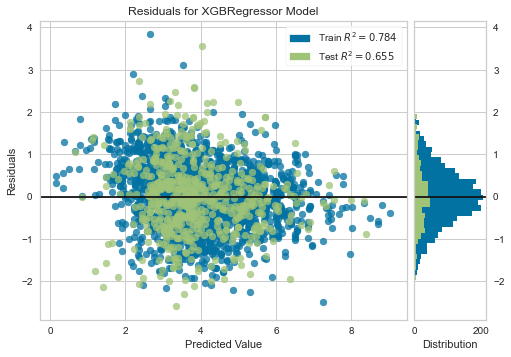

In [36]:
visualizer = ResidualsPlot(final_model_co2)
visualizer.fit(X_train, y_train.reshape(2596,))
visualizer.score(X_test, y_test.reshape(649,))
visualizer.show();

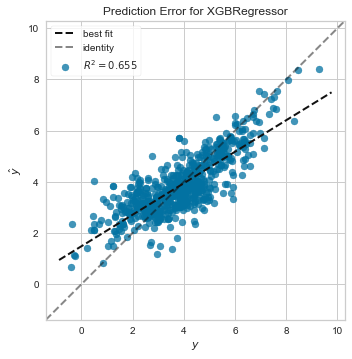

In [37]:
visualizer = prediction_error(final_model_co2, X_train, y_train, X_test, y_test);

## 3.6) Pipeline du modèle pour l'estimation des émissions de CO2 <a class="anchor" id="section_3_6"></a>

In [38]:
full_pipeline_co2 = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_co2)
])

# 4 - Prédiction des émissions de CO2 avec ENERGY STAR SCORE

In [39]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["PrimaryPropertyType"])

y_train = train_set["TotalGHGEmissions"].values
y_test = test_set["TotalGHGEmissions"].values
X_train = train_set.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "YearBuilt", "Age", "NumberofFloors", "NumberofBuildings", "Neighborhood", "Latitude", "Longitude"], axis=1)
X_test = test_set.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "YearBuilt", "Age", 'Neighborhood', "NumberofBuildings", "NumberofFloors", "Latitude", "Longitude"], axis=1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [40]:
# Séparation des variables catégorielles et numériques

cat_var = ["PrimaryPropertyType", "NbofFloors", "NbofBuildings", "HasParking", "Clusters", "Bins_Age"]
num_var = ["PropertyGFATotal", "degreeDaysH", "degreeDaysC", "ENERGYSTARScore"]

In [41]:
# Création d'un pipeline de transformation

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [42]:
X_train = preprocessor.fit_transform(X_train)

In [43]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [44]:
X_test = preprocessor.transform(X_test)
y_pred = dummy_reg.predict(X_test)
regression_metrics(y_test, y_pred)

MAE:  1.1754
MSE:  315765.27998
RMSE:  561.92996
R²:  -0.00404


In [45]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
mlp_reg = MLPRegressor(random_state=42)

In [46]:
model = [dummy_reg, lin_reg, ridge, lasso, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost, mlp]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
    rmse = mse ** (1/2)
    r_score = r2_score(y_test, y_pred)
    dict_model[model] = (mae, mse, rmse, r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost", "MLP"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost,MLP
MAE,1.175397,0.917128,0.914282,1.180480,0.623003,0.778185,0.914397,0.898815,0.605901,0.729444,0.568918,0.541489,0.745330
MSE,315765.279982,94442.120218,103873.935180,315252.519058,125477.032253,174534.901629,103303.655300,213410.938880,31665.512977,85636.740569,36028.529935,49363.063859,84099.985590
RMSE,561.929960,307.314367,322.294795,561.473525,354.227374,417.773745,321.408860,461.964218,177.948063,292.637558,189.811828,222.178000,289.999975
R²,-0.004040,0.388934,0.392655,-0.008795,0.535226,0.533078,0.392666,0.452054,0.706539,0.621610,0.744379,0.757458,0.585639


In [47]:
xgboost_ghg_energystar = xgb.XGBRegressor(objective="reg:squarederror", booster="gbtree", 
                               random_state=42, n_estimators=400, tree_method="hist", n_jobs=-1)

In [48]:
params = [{"max_depth" : [7, 8, 9, 10, 11, 12],
           "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
           "gamma" : [3, 4, 5, 6],
           "min_child_weight" : [2, 3, 4, 5, 6],
           "sampling_method" : ["uniform", "gradient_based"]
}]

grid_search = GridSearchCV(xgboost_co2, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
final_model_ghg = grid_search.best_estimator_

In [ ]:
final_prediction_ghg = final_model_ghg.predict(X_test)

In [ ]:
regression_metrics(y_test, final_prediction_ghg)

In [ ]:
visualizer = ResidualsPlot(final_model_ghg)
visualizer.fit(X_train, y_train.reshape(2596,))
visualizer.score(X_test, y_test.reshape(649,))
visualizer.show();

In [ ]:
visualizer = prediction_error(final_model_ghg, X_train, y_train, X_test, y_test);

In [ ]:
full_pipeline_ghg = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_ghg)
])

# 5 - Conclusion <a class="anchor" id="chapter1"></a>